# Shapley effects for the Rust Model

In [53]:
# Import statements as in simulation_convergence.ipynb.
import matplotlib.pyplot as plt
#import yaml
import numpy as np
from ruspy.simulation.simulation import simulate
from ruspy.model_code.fix_point_alg import calc_fixp
from ruspy.model_code.cost_functions import lin_cost
from ruspy.model_code.cost_functions import calc_obs_costs
from ruspy.estimation.estimation_transitions import create_transition_matrix

# My imports.
import chaospy as cp
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from ruspy.estimation.estimation import estimate
from ruspy.model_code.demand_function import get_demand 
from python.econsa_shapley import get_shapley

## Understand simulation capabilities of `ruspy`
The below code is taken from the notebook simulation_convergence provided as promotional material for `ruspy`.

In [23]:
# Set simulating variables
disc_fac = 0.9999
num_buses = 50
num_periods = 120
gridsize = 1000
# We use the cost parameters and transition probabilities from the replication
params = np.array([10.07780762, 2.29417622])
trans_probs = np.array([0.39189182, 0.59529371, 0.01281447])
scale = 1e-3

init_dict_sim = {
    "simulation": {
        "discount_factor": disc_fac,
        "periods": num_periods,
        "seed": 123,
        "buses": num_buses,
    },
    "plot": {"gridsize": gridsize},
}

In [24]:
# Calucalte objects necessary for the simulation process. See documentation for details.
num_states = 200
costs = calc_obs_costs(num_states, lin_cost, params, scale)

trans_mat = create_transition_matrix(num_states, trans_probs)
ev = calc_fixp(trans_mat, costs, disc_fac)[0]

In [25]:
# Can use one init_dict for get_demand() and estimate().
init_dict_estimation = {
    'model_specifications': {
        'discount_factor': disc_fac,
        'number_states': num_states,
        'maint_cost_func': 'linear',
        'cost_scale': 1e-3
    },
    'optimizer': {
        'approach': 'NFXP',
        'algorithm': 'scipy_L-BFGS-B',
        'gradient': 'Yes'
    },
    
}

In [65]:
%%time

# Define number of simulations.
num_sim = 10

# Initialize array to save parameter estimates.
parameter_estimates = np.zeros((num_sim, len(params) + len(trans_probs)))

for i in np.arange(num_sim):
    
    init_dict_sim['simulation']['seed'] = +i
    
    df = simulate(init_dict_sim["simulation"], ev, costs, trans_mat)
    data = df[['state', 'decision', 'usage']].copy()
    
    result_transitions_nfxp, result_fixp_nfxp = estimate(init_dict_estimation, data)
    
    parameter_estimates[i, :] = np.concatenate((result_transitions_nfxp['x'], result_fixp_nfxp['x']))

Wall time: 26.2 s


In [66]:
#parameter_estimates

In [67]:
cov = np.cov(parameter_estimates.T)

In [68]:
mean = np.mean(parameter_estimates, axis=0)

In [89]:
distribution = cp.MvNormal(mean, cov)
parameter_samples = pd.DataFrame(data=(distribution.sample(1000).T),
                                 columns=('t_30', 't_31', 't_32', 'RC', 't_11'),
                                )

In [90]:
parameter_samples

,t_30,t_31,t_32,RC,t_11
0,0.389993,0.601214,0.008793,15.277831,4.184055
1,0.379289,0.610678,0.010033,13.188973,3.650713
2,0.390485,0.594396,0.015119,9.062711,1.989339
3,0.399582,0.585034,0.015383,9.942543,2.163304
4,0.380437,0.609675,0.009888,11.087023,2.591136
...,...,...,...,...,...
995,0.386803,0.603870,0.009327,11.365733,3.157889
996,0.388454,0.597132,0.014414,6.950470,0.352765
997,0.390493,0.596468,0.013039,9.742381,1.911871
998,0.389304,0.595666,0.015030,9.213288,1.822213


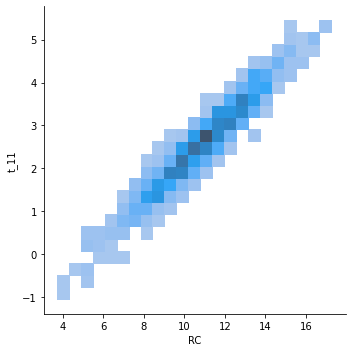

In [91]:
# Plot distributions.
sns.displot(parameter_samples, x='RC', y='t_11')